## Feature Engineer
This is the first in a series of three notebooks for the ODSC presentation 'Harnessing GPT Assistants for Superior Model Ensembles: A Beginner's Guide to AI STacked-Classifiers' ODSC East -- Jason Merwin

In [1]:
import time
import openai
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pandas as pd
from io import StringIO
import io
import json
import warnings

from config import OPENAI_API_KEY
warnings.filterwarnings('ignore', category=FutureWarning)

## Define Functions 
def delete_all_agents():
    ''' Deletes all exising Assistants associated with API key '''
    # Fetch the list of assistants
    my_assistants = client.beta.assistants.list(order="desc", limit=20)
    asst_ids = [asst.id for asst in my_assistants.data]
    print(f'Deleting {len(asst_ids)} assistants.')
    # Delete each assistant
    for asst_id in asst_ids:
        client.beta.assistants.delete(asst_id)
        print(f"Deleted assistant with ID: {asst_id}")
        time.sleep(1)
    print('Finished deleting all assistants')
    
def delete_all_assistant_files():
    ''' Deletes all exising files uploaded to OpenAI client using API key '''
    # generate a files object
    files_object = client.files.list()
    # get a list comprehension
    file_ids = [file.id for file in files_object.data]
    print(f'Deleting {len(file_ids)} files.')
    #delete them all
    for file_id in file_ids:
        client.files.delete(file_id)
        print(f"Deleted file with ID: {file_id}")
        time.sleep(1)
    print('Finished deleting all files')  

def upload_csv(file_name):
    """
    Sends a csv file to OpenAI and returns the file id
    file_name: string for name and ext of saved file. Example: "analyst_output.csv"
    return: file id
    """
    response = client.files.create(
        file=open(file_name, "rb"),
        purpose="assistants")
    print(response)
    file_id = response.id
    return file_id

def read_and_save_file(first_file_id, file_name):  
    """
    Reads the file contents from OpenAI file id and saves as csv.
    first_file_id: OpenAI file id
    file_name: string for name and ext of saved file. Example: "analyst_output.csv"
    """
    # its binary, so read it and then make it a file like object
    file_data = client.files.content(first_file_id)
    file_data_bytes = file_data.read()
    file_like_object = io.BytesIO(file_data_bytes)
    #now read as csv to create df
    returned_data = pd.read_csv(file_like_object)
    returned_data.to_csv(file_name, index=False)
    return returned_data

def files_from_messages(messages, asst_name):
    """
    Returns a csv data file from an OpenAI API message object.
    messages: OpenAI API messages object
    asst_name: string name of Assistant for use when saving file
    """
    first_thread_message = messages.data[0]  
    message_ids = first_thread_message.file_ids
    print(message_ids)
    # Loop through each file ID and save the file with a sequential name
    for i, file_id in enumerate(message_ids):
        file_name = f"{asst_name}_output_{i+1}.csv" 
        read_and_save_file(file_id, file_name)
        print(f'saved {file_name}')
        
def get_string_features(df):
    """
    Returns a list of column names in the DataFrame that are of string type.
    param df: pandas DataFrame
    return: List of column names that are strings
    """
    # Select columns of object dtype (commonly used for strings)
    string_columns = df.select_dtypes(include=['object']).columns.tolist()
    return string_columns  

def convert_strings_to_numbers(df, columns_to_convert):
    """
    Converts unique string values in specified columns to increasing numeric values.
    param df: pandas DataFrame
    param columns_to_convert: List of column names to be converted
    return: DataFrame with specified columns converted to numeric values
    """
    for column in columns_to_convert:
        # Ensure the column is in the DataFrame
        if column in df.columns:
            # Create a mapping from unique strings to numbers
            unique_strings = df[column].unique()
            string_to_number_mapping = {string: i for i, string in enumerate(unique_strings)}
            # Apply the mapping to the column
            df[column] = df[column].map(string_to_number_mapping)
        else:
            print(f"Column '{column}' not found in DataFrame.")
    return df

# Upload Data Set and Explore

In [2]:
# upload data set and define target
training_df = pd.read_csv('apple_quality.csv')
target = 'Quality'
print(training_df.shape)
training_df.tail()

(4001, 9)


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [3]:
#remove last row
training_df = training_df.drop(training_df.index[-1])

# Calculate the percentage of null values for each column
percent_missing = training_df.isnull().mean() * 100
print(percent_missing)

# check class distribution
normalized_distribution = training_df[f'{target}'].value_counts(normalize=True)
print(f'The percentage of class values in the data set are {normalized_distribution}')

A_id           0.0
Size           0.0
Weight         0.0
Sweetness      0.0
Crunchiness    0.0
Juiciness      0.0
Ripeness       0.0
Acidity        0.0
Quality        0.0
dtype: float64
The percentage of class values in the data set are Quality
good    0.501
bad     0.499
Name: proportion, dtype: float64


In [4]:
# make copy of training data
train_df = training_df.copy()

# Make changes (optional)
col_to_drop = ['A_id']
train_df.drop(col_to_drop, axis=1, inplace=True)
train_df['Quality'] = train_df['Quality'].replace({'bad': 0, 'good': 1})

print(train_df.shape)
print(train_df.tail())

(4000, 8)
          Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness  \
3995  0.059386 -1.067408  -3.714549     0.473052   1.697986  2.244055   
3996 -0.293118  1.949253  -0.204020    -0.640196   0.024523 -1.087900   
3997 -2.634515 -2.138247  -2.440461     0.657223   2.199709  4.763859   
3998 -4.008004 -1.779337   2.366397    -0.200329   2.161435  0.214488   
3999  0.278540 -1.715505   0.121217    -1.154075   1.266677 -0.776571   

           Acidity  Quality  
3995   0.137784369        0  
3996   1.854235285        1  
3997  -1.334611391        0  
3998  -2.229719806        1  
3999   1.599796456        1  


In [5]:
# save the encoded training data
train_df.to_csv('pre_assistant_train.csv', index=False)
encoded_train = pd.read_csv('pre_assistant_train.csv')
encoded_train

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1
...,...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,0
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,1
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,0
3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,1


# Send data set to Assistant for Feature Engineering and Selection

In [6]:
# Instantiate the OpenAI client
client = openai.OpenAI(api_key=OPENAI_API_KEY)

In [7]:
# clean up any existing assistants and files
delete_all_agents()   
delete_all_assistant_files()

Deleting 0 assistants.
Finished deleting all assistants
Deleting 0 files.
Finished deleting all files


In [8]:
# create the assistant and give it the CSV file

prompt = f'''
You are a feature engineer who will create and test new features from a csv data set in your files. 
When the user asks you to perform your actions, use the csv file to read the data into a pandas dataframe.
The data set contains predictive features that will be used for a binary classifier.
Follow each of the steps listed below in your ACTIONS. The target variable is {target}. 

ACTIONS:
1. Read the file data into a pandas DataFrame. 
2. Check for missing values and impute the column mean for those missing values.
3. Numerically encode any categorical columns.
4. Create new feature interaction columns using the continuous, non categorical columns. For each unique pair of columns create a new column that is the result of multiplying one column by the other and a second column that is the result of dividing one column by the other. 
5. Add these new features to the original data set and train an extra trees random forest with 3,000 trees to predict the target variable {target}. 
6. Get the feature importances of all the features in the model and prepare the feature importance values as Table_1. This table should have one column for the features name and one for the importance value.
7. Now prepare a final training data set that contains the original continuous features, numerically encoded features, and the top 3 feature interactions. Prepare this final table as Table_2. Table 2 should have 11 columns: the orignal columns, the top 3 feature interactions, and the target {target}.
8. Prepare Table_1 and Table_2 for download by the user. 
9. Please only respond once, with both tables once they are ready for download.

DO NOT:
1. Do not return any images. 
2. Do not return any other tables besides Table_1 and Table_2
3. Do not use the target column {target} in the feature interactions.
4. When adding the top 3 feature interactions to the final data set, do not add original features, only feature interactions derived from pairs of original features.

'''

# send the csv file to the assistant purpose files
training_file_id = upload_csv('pre_assistant_train.csv')

# create the assistant and link to file
my_assistant = client.beta.assistants.create(
    instructions=prompt,
    name="feature_engineer",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-turbo-preview", 
    file_ids=[training_file_id]
)

# get the assistant file id
fileId = my_assistant.file_ids[0]
print(my_assistant)

FileObject(id='file-dpRMdyvBAbZU0So974wbXYAM', bytes=358707, created_at=1714062099, filename='pre_assistant_train.csv', object='file', purpose='assistants', status='processed', status_details=None)
Assistant(id='asst_WXbgpKUFktsfMO84lXhz6NIQ', created_at=1714062099, description=None, file_ids=['file-dpRMdyvBAbZU0So974wbXYAM'], instructions='\nYou are a feature engineer who will create and test new features from a csv data set in your files. \nWhen the user asks you to perform your actions, use the csv file to read the data into a pandas dataframe.\nThe data set contains predictive features that will be used for a binary classifier.\nFollow each of the steps listed below in your ACTIONS. The target variable is Quality. \n\nACTIONS:\n1. Read the file data into a pandas DataFrame. \n2. Check for missing values and impute the column mean for those missing values.\n3. Numerically encode any categorical columns.\n4. Create new feature interaction columns using the continuous, non categorical

In [9]:
# make the request to the assistant
message_string = f"Please execute your ACTIONS on the data stored in the csv file {fileId}. The Target variable is {target}"
print(message_string)

# Create a Thread
thread = client.beta.threads.create()
print('created thread')

# Add a Message to a Thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content= message_string
)
print('added message to thread')

# Run the Assistant
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=my_assistant.id
    #instructions="you can overwrite prompt instructions here"
)
print('running the client')

print('getting json response')
print(run.model_dump_json(indent=4))

Please execute your ACTIONS on the data stored in the csv file file-dpRMdyvBAbZU0So974wbXYAM. The Target variable is Quality
created thread
added message to thread
running the client
getting json response
{
    "id": "run_lsBaVllI903KUhFUlZsrwxcz",
    "assistant_id": "asst_WXbgpKUFktsfMO84lXhz6NIQ",
    "cancelled_at": null,
    "completed_at": null,
    "created_at": 1714062159,
    "expires_at": 1714062759,
    "failed_at": null,
    "file_ids": [
        "file-dpRMdyvBAbZU0So974wbXYAM"
    ],
    "instructions": "\nYou are a feature engineer who will create and test new features from a csv data set in your files. \nWhen the user asks you to perform your actions, use the csv file to read the data into a pandas dataframe.\nThe data set contains predictive features that will be used for a binary classifier.\nFollow each of the steps listed below in your ACTIONS. The target variable is Quality. \n\nACTIONS:\n1. Read the file data into a pandas DataFrame. \n2. Check for missing values a

In [10]:
# let an initial 4 minutes pass
time.sleep(120) 

# check for a response
while True:
    time.sleep(30) 
    # Retrieve the run status
    run_status = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id)
    if run_status.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread.id)
        # Loop through messages and print content based on role
        for msg in messages.data:
            role = msg.role
            try:
                content = msg.content[0].text.value
                print(f"{role.capitalize()}: {content}")
            except AttributeError:
                # This will execute if .text does not exist
                print(f"{role.capitalize()}: [Non-text content, possibly an image or other file type]")
        break

Assistant: The actions have been successfully executed, and the results are prepared in two tables as requested:

- Table_1 with feature importances: [Download Table_1](sandbox:/mnt/data/Table_1.csv)
- Table_2 with original continuous features, numerically encoded features, and the top 3 feature interactions: [Download Table_2_corrected](sandbox:/mnt/data/Table_2_corrected.csv)
Assistant: It appears there was an error while preparing Table_2 due to a type mismatch in manipulating DataFrame columns. Let me correct this and proceed with the solution.
User: Please execute your ACTIONS on the data stored in the csv file file-dpRMdyvBAbZU0So974wbXYAM. The Target variable is Quality


In [11]:
# extract the file names from the response and retrieve the content
asst_name = 'feature_engineer'        
files_from_messages(messages, asst_name)

['file-8grttuOZwzwJj3Vz94864D0A']
saved feature_engineer_output_1.csv


In [13]:
df1 = pd.read_csv('feature_engineer_output_1b.csv')
display(df1)

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Sweetness*Ripeness,Size*Ripeness,Size*Acidity,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1.763432,-1.309480,1.951638,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,3.178681,-1.036887,0.863914,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0.066118,0.011107,-0.765580,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,-4.522803,2.243510,-0.519660,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,0.501536,-1.778733,0.684815,1
...,...,...,...,...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,-8.335650,0.133266,0.008183,0
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,0.221953,0.318883,-0.543510,1
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,-11.626014,-12.550460,3.516054,0
3998,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,0.507565,-0.859670,8.936725,1


,Features,Importance
33,Sweetness*Ripeness,0.045959
4,Juiciness,0.045073
5,Ripeness,0.044119
0,Size,0.040404
2,Sweetness,0.039756


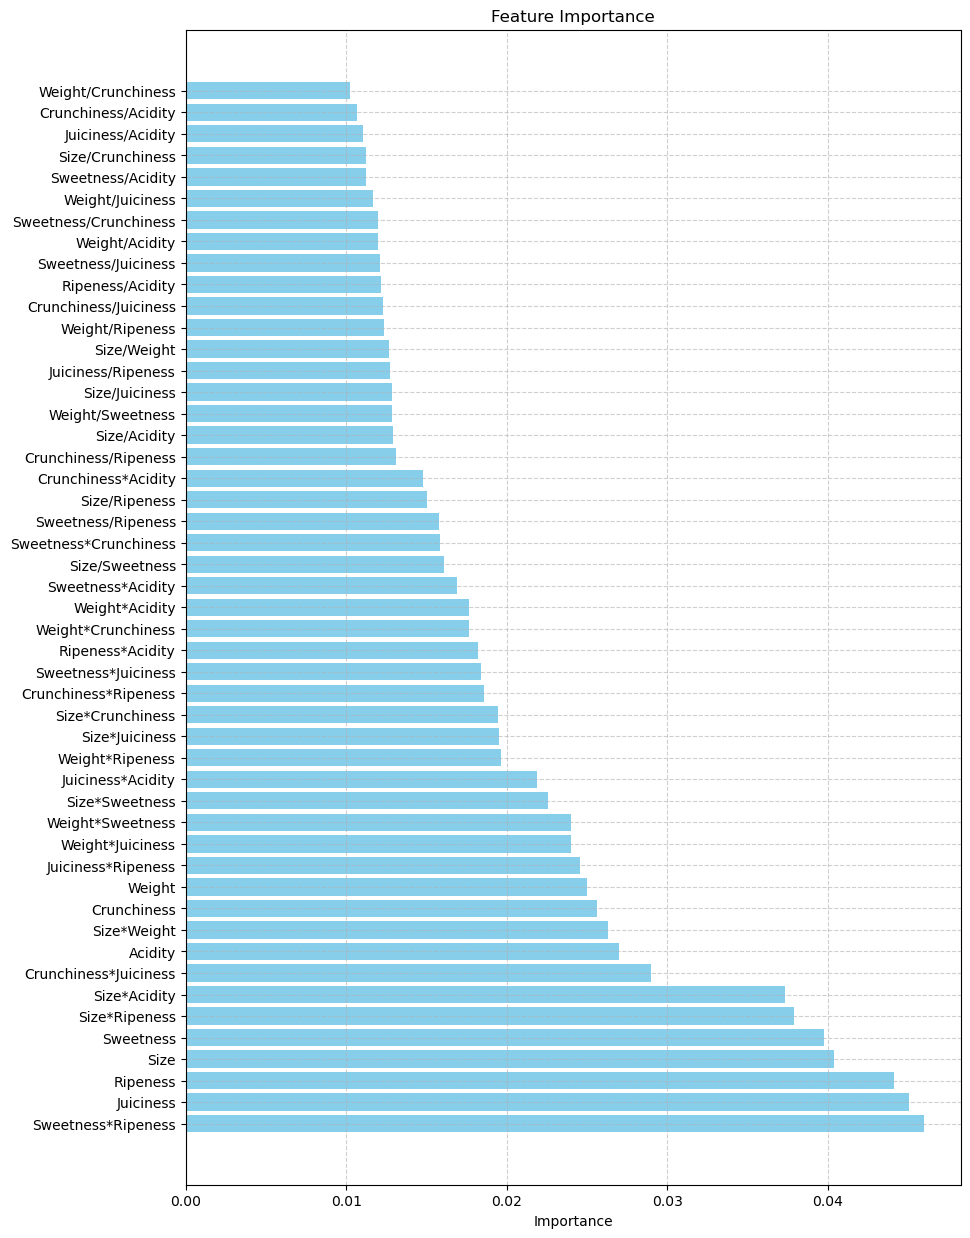

In [14]:
import matplotlib.pyplot as plt

df2 = pd.read_csv('feature_engineer_output_2b.csv')
df2 = df2.sort_values(by='Importance', ascending=False)
display(df2.head())

# Creating the plot
plt.figure(figsize=(10, 15))
plt.barh(df2['Features'], df2['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(True, linestyle='--', alpha=0.6)  

# Show plot
plt.show()